In [1]:
!pip install gym

In [2]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [5]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.2((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.2((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [7]:
def plot_test_game(env, pi1, pi2, random_1=False, random_2=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_1, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_2, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

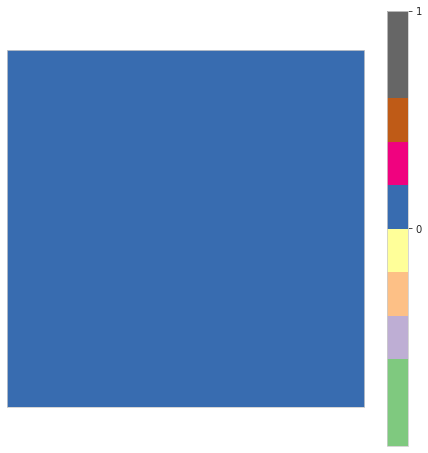

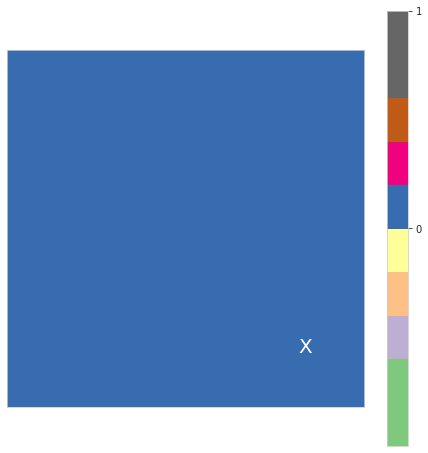

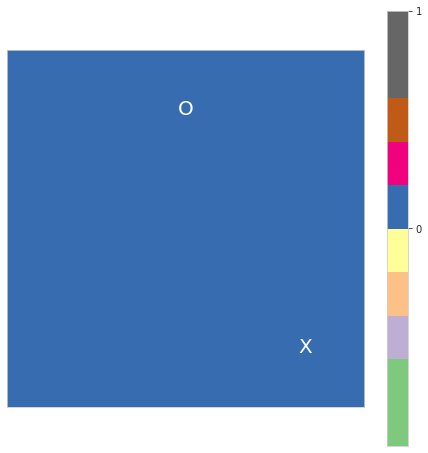

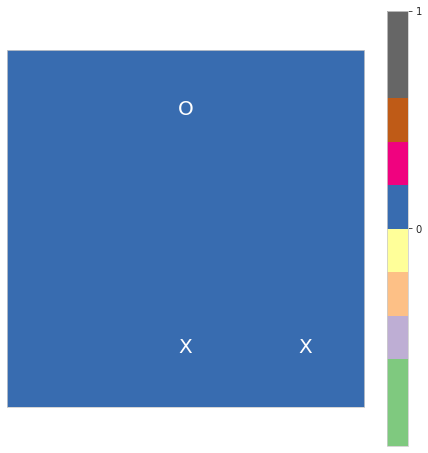

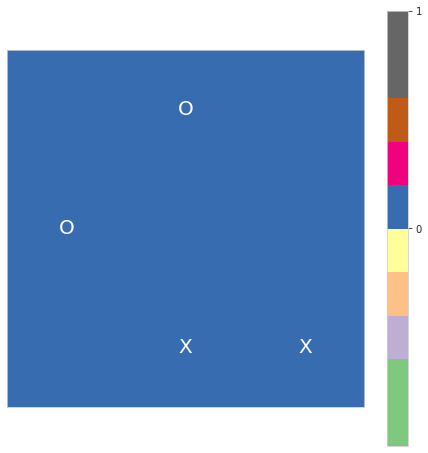

Крестики выиграли!


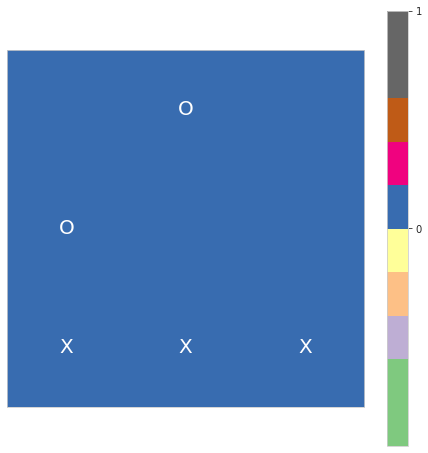

In [9]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_1=True, random_2=True, verbose=True, fontx=20)

**Часть первая:** 




Крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.



In [127]:
class R_Agent(object):
    def __init__(self):
        self.index_best_action = True
        pass

    def get_best_action(self, state, n_actions=None):
        if n_actions is None:
            n_actions = np.sum(np.array(list(state)) == '1')
        return np.random.randint(n_actions)

In [128]:
class QL_Agent:
    def __init__(self, alpha=0.55, epsilon=0.1, gamma=0.7):
        self.index_best_action = True

        self.Q = {}
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        
    
    def Q_action(self, state, n_actions=None):
        if state not in self.Q:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            #self.Q[state] = np.2(n_actions)
            self.Q[state] = np.random.random(n_actions) * 0.01 - 0.005
        return self.Q[state]

    def get_V(self, state):
        return np.max(self.Q_action(state))

   
    def update_Q(self, state, n_action, reward, next_state):
        Q = self.Q_action(state)[n_action]
        if next_state is None:
            V = 0
        else:
            V = self.get_V(next_state)
            
        self.Q[state][n_action] = Q + self.alpha * (reward + self.gamma * V - Q)

    def get_best_action(self, state, n_actions=None):
        return np.argmax(self.Q_action(state, n_actions))

    # epsilon-greedy action
    def select_action(self, state, epsilon, n_actions=None):
        if np.random.random() > epsilon:
            return self.get_best_action(state, n_actions)
        else:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            return np.random.randint(n_actions)

In [129]:
def test_policy(env, pi_1, pi_2, num_games=1000):
    w1 = 0
    w2 = 0
    for _ in range(num_games):
        reward = play_game(env, pi_1, pi_2)
        if reward == 1:
            w1 += 1
        elif reward == -1:
            w2 += 1
    return w1 / num_games, w2 / num_games

In [130]:
def play_game(env, pi_1, pi_2):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        n_actions = len(actions)
        if env.curTurn == 1:
            if pi_1.index_best_action:
                a = actions[pi_1.get_best_action(s, n_actions)]
            else:
                a = pi_1.get_best_action(s)
        else:
            if pi_2.index_best_action:
                a = actions[pi_2.get_best_action(inv_state(s), n_actions)]
            else:
                a = pi_2.get_best_action(inv_state(s))
        observation, reward, done, info = env.step(a)
        if reward < -1:
            print("Ход в занятую клетку")
    return reward

def inv_state(s):
    return ''.join([str(2 - int(n)) for n in s])

In [133]:
def QL_train(env, QL_agent,R, max_epsilon, epochs):
    hist_1 = []
    hist_2 = []
    for e in range(epochs):
        
        epsilon = max_epsilon * (epochs - e) / epochs

        if e % (epochs // 5) == 0:
            p, _ = test_policy(env, QL_agent, R)
            hist_1.append((e, p))
            _, p = test_policy(env, R, QL_agent)
            hist_2.append((e, p))
            
        done = False
        env.reset()

        state_0, actions_0 = env.getHash(), env.getEmptySpaces()
        n_action_0 = QL_agent.select_action(state_0, epsilon, len(actions_0))
        observation, reward, done, info = env.step(actions_0[n_action_0])
        state_1, actions_1 = observation[0], observation[1]
        curTurn = env.curTurn
        state_1 = inv_state(state_1)
        while not done:
            n_action_1 = QL_agent.select_action(state_1, epsilon, len(actions_1))
            observation, reward, done, info = env.step(actions_1[n_action_1])
            if done: 
                QL_agent.update_Q(state_0, n_action_0, -reward * curTurn, None)
                QL_agent.update_Q(state_1, n_action_1, reward * curTurn, None)
                break

            next_state = observation[0]
            curTurn = env.curTurn
            if curTurn == -1:
                next_state = inv_state(next_state)
                
            QL_agent.update_Q(state_0, n_action_0, reward, next_state)
            state_0, actions_0 = state_1, actions_1
            state_1, actions_1 = next_state, observation[1]
            n_action_0 = n_action_1
            
    return hist_1, hist_2

In [135]:
#alpha = 0.5
#gamma = 0.7
#epsilon =0.1
env= TicTacToe(n_rows=3, n_cols=3, n_win=3)
alpha = 0.09
gamma = 0.7
epsilon =0.1
QL = QL_Agent(alpha,epsilon, gamma)
R = R_Agent()
epochs = 100000
hist_1, hist_2 = QL_train(env, QL,R,epsilon,epochs)

In [137]:
def plot_results(hist_1, hist_2):
    steps = [x[0] for x in hist_1]
    rewards_1 = [x[1] for x in hist_1]
    rewards_2 = [x[1] for x in hist_2]
    plt.plot(steps, rewards_1, label='x')
    plt.plot(steps, rewards_2, label='o')
    plt.grid()
    plt.xlabel("Шаг обучения")
    plt.ylabel("Доля выигрышей")
    plt.title("Игры против игрока со случайными ходами")
    plt.legend()
    plt.ylim(0, 1.1)

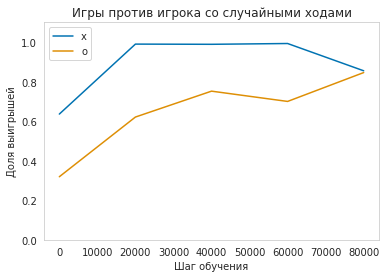

In [138]:
plot_results(hist_1, hist_2)

In [141]:
#alpha = 0.5
#gamma = 0.7
#epsilon =0.1
env= TicTacToe(n_rows=4, n_cols=4, n_win=4)
alpha = 0.5
gamma = 1.0
epsilon =0.5
QL = QL_Agent(alpha,epsilon, gamma)
R = R_Agent()
epochs = 100000
hist_1, hist_2 = QL_train(env, QL,R,epsilon,epochs)

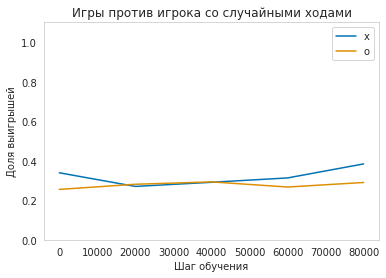

In [142]:
plot_results(hist_1, hist_2)

**Часть вторая: добавим нейронных сетей**




Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.


In [143]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [144]:
class Network_4_4(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
class Network_3_3(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.l1 = nn.Linear(conv_out * 2, conv_out)
        self.l2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

def s_to_tensor(s):
    s = np.array([int(c) for c in s])
    size = int(np.sqrt(len(s)))
    pi_1 = np.where(s==2, 1, 0).reshape(size, size)
    pi_2 = np.where(s==0, 1, 0).reshape(size, size)
    empty_spaces = np.where(s==1, 1, 0).reshape(size, size)
    return torch.Tensor(np.stack([pi_1, pi_2, empty_spaces])).reshape(3, size, size)

In [145]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [146]:
class TicTacToeDQN():
    def __init__(self, n_rows=4, n_cols=4, n_win=4, model_class=Network_4_4, gamma=0.8, device=device):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.device = device
        self.models = {-1: model_class().to(device), 1: model_class().to(device)}
        self.memories = {-1: ReplayMemory(1000000), 1: ReplayMemory(1000000)}
        self.optimizers = {-1: optim.Adam(self.models[-1].parameters(), lr=0.0001, weight_decay=0.001),
                            1: optim.Adam(self.models[1].parameters(), lr=0.0001, weight_decay=0.001)}
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        self.steps_done = 0
        
        self.gamma = gamma
        self.batch_size = 512
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0

    def select_greedy_action(self, state, cur_turn):
        return self.models[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, cur_turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        state, _, cur_turn = self.env.getState()
        while True:
            state_tensor = s_to_tensor(state)
            with torch.no_grad():
                if greedy:
                    action_idx = self.select_greedy_action(state_tensor.to(self.device), cur_turn).cpu()
                else:
                    action_idx = self.select_action(state_tensor.to(self.device), cur_turn).cpu()
            # Сохраняем позицию и совершаемое действие
            self.previous_states[cur_turn] = state_tensor
            self.previous_actions[cur_turn] = action_idx
            action = self.env.action_from_int(action_idx.numpy()[0][0])
            (next_state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            next_state_tensor = s_to_tensor(next_state)
            if reward == -10:
                transition = (state_tensor, action_idx, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memories[cur_turn].store(transition)
            else:
                if self.previous_states[cur_turn] is not None:
                    if reward == -cur_turn: # Последний ходивший игрок выиграл, текущий cur_turn проиграл - дополним память победителя
                        transition = (self.previous_states[-cur_turn], 
                                      self.previous_actions[-cur_turn], 
                                      next_state_tensor, 
                                      torch.tensor([1.0], dtype=torch.float32)
                                     )
                        self.memories[-cur_turn].store(transition)
                    transition = (self.previous_states[cur_turn], 
                                  self.previous_actions[cur_turn], 
                                  next_state_tensor, 
                                  torch.tensor([reward * cur_turn], dtype=torch.float32)
                                 )
                    self.memories[cur_turn].store(transition)

            
            if do_learning:
                self.learn(cur_turn)

            state = next_state

            if done:
                break

    def learn(self, cur_turn):
        if np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])]) < self.batch_size:
            return
        
        # берём мини-батч из памяти
        transitions = self.memories[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))
        
        # считаем значения функции Q
        Q = self.models[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.models[cur_turn](batch_next_state).detach()
        Qmax = Qmax.max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizers[cur_turn].zero_grad()
        loss.backward()
        
        self.optimizers[cur_turn].step()
        
    def test_strategy(self, player, n_episodes=1000):
        rewards = []
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            done = False
            while not done:
                if cur_turn == player:
                    idx = self.select_greedy_action(s_to_tensor(state).to(device), player)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            if reward != -10:
                rewards.append(reward * player)
            else:
                if cur_turn == player:
                    rewards.append(reward)
        return np.array(rewards)

In [147]:
def learn_to_play(learner, total_episodes, test_episodes):
    pi_1_win = []
    pi_1_draw = []
    pi_1_lose = []
    pi_1_fail = []
    pi_2_win = [] 
    pi_2_draw = []
    naughts_lose = []
    naughts_fail = []

    for i in tqdm.tqdm(range(1, total_episodes + 1)):
        learner.run_episode(do_learning=True)
        if i % 1000 == 0:
            pi_1 = learner.test_strategy(1, test_episodes)
            pi_2 = learner.test_strategy(-1, test_episodes)
            pi_1_win.append(np.sum(pi_1==1)/1000)
            pi_1_draw.append(np.sum(pi_1==0)/1000)
            pi_1_lose.append(np.sum(pi_1==-1)/1000)
            pi_1_fail.append(np.sum(pi_1==-10)/1000)
            pi_2_win.append(np.sum(pi_2==1)/1000)
            pi_2_draw.append(np.sum(pi_2==0)/1000)
            naughts_lose.append(np.sum(pi_2==-1)/1000)
            naughts_fail.append(np.sum(pi_2==-10)/1000)
    return (pi_1_win, pi_1_draw, pi_1_lose, pi_1_fail), (pi_2_win, pi_2_draw, naughts_lose, naughts_fail)

In [148]:
def show_results(pi_1, pi_2, period = 1000):
    plt.figure(figsize=(10, 6))
    plt.plot(pi_1[0], label='pi_1_win')
    plt.plot(pi_1[1], label='pi_1_draw')
    plt.plot(pi_1[2], label='pi_1_lose')
    plt.plot(pi_1[3], label='pi_1_fail')
    plt.plot(pi_2[0], label='pi_2_win')
    plt.plot(pi_2[1], label='pi_2_draw')
    plt.plot(pi_2[2], label='pi_2_lose')
    plt.plot(pi_2[3], label='pi_2_fail')
    plt.xlabel(f'{period} эпизодов')
    plt.ylabel('Процент исходов')
    plt.legend(loc='lower left')

100%|██████████| 30000/30000 [21:00<00:00, 23.80it/s]


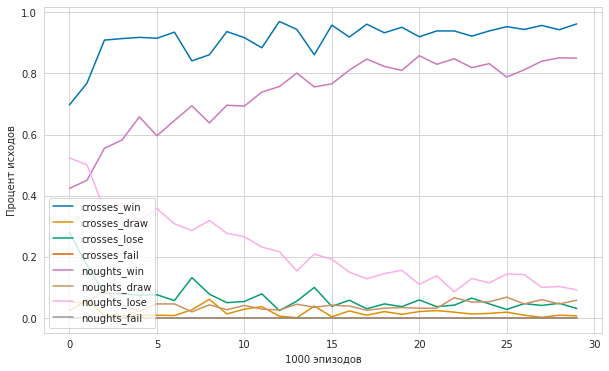

In [149]:
learner_3_3 = TicTacToeDQN(3, 3, 3, Network_3_3)
pi_1, pi_2 = learn_to_play(learner_3_3, 30000, 1000)
show_results(pi_1, pi_2)